# Makemore Part 3

> Activations and Gradients, Batchnorm

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
words = open('../names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
''.join(words[:2]), set(''.join(words[:2]))

('emmaolivia', {'a', 'e', 'i', 'l', 'm', 'o', 'v'})

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 #add special dot character to the vocabulary
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 27.8817


The initial loss is way too high because the net is assigning a large probability to an incorrect prediction (this means that the correct next character has a teeny probability assigned to it and we end up getting hit with a high loss). Recall that log of values close to 0 goes to minus infinity. 

In [ ]:
# initial logits all over the place. Resulting in misplaced high confidence
# on an incorrect prediction
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [ ]:
# However what we want the net to do is to output uniform probabilities 
# for the next character and hence obtain the following loss:
-torch.tensor(1/27.).log()

tensor(3.2958)

In [ ]:
# infinite loss for this contrived 4-d example
logits = torch.tensor([0.,5000.,0.,0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([   0., 5000.,    0.,    0.]), tensor([0., 1., 0., 0.]), tensor(inf))

In [ ]:
# rather we want at the initial step for the net
# to output a uniform probability for the next
# character
# Though we only want them to be roughly the same
# and not exactly the same for the purposes of 
# symmetry breaking.
logits = torch.tensor([0.,0.,0.,0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So in the output layer let's set:

* the biases to zero 
* multiply the weights by a small number

so they cannot contribute to the initial predictions being all over the place.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01
b2 = torch.randn(vocab_size,                      generator=g)*0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221


<matplotlib.image.AxesImage>

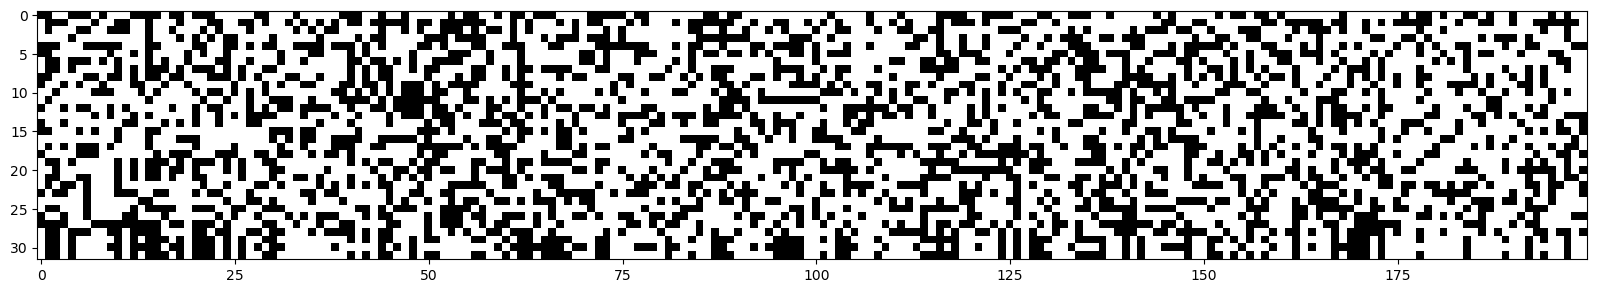

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')#white if True i.e., activations are  > 0.99 (and Black if False)

In the plot above, each row is a training example and each column is one of our 200 neurons. We would be in trouble if any column was completely white. That means that we have a dead neuron and gradient is not flowing back. 

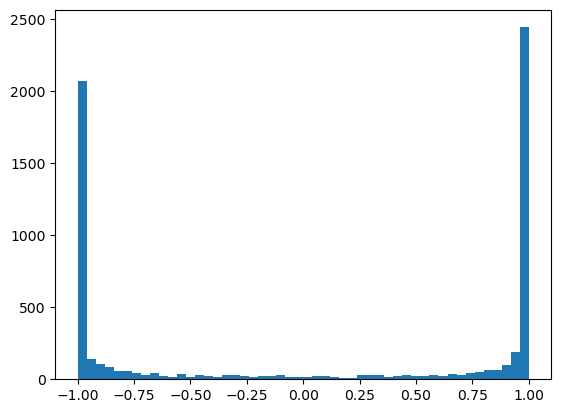

In [ ]:
plt.hist(h.view(-1).tolist(),bins=50);

tanh saturates, roughly speaking, if the inputs are > 5 or <= -5

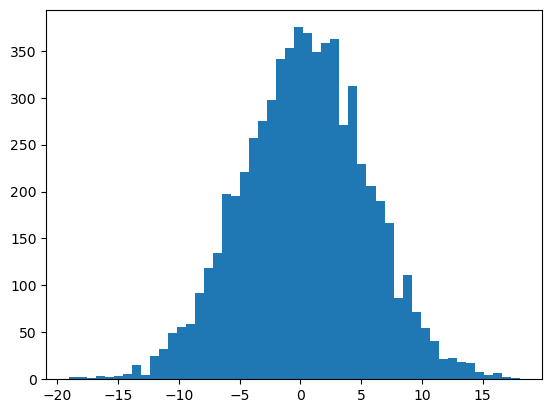

In [ ]:
plt.hist(hpreact.view(-1).tolist(),bins=50);

[<matplotlib.lines.Line2D>]

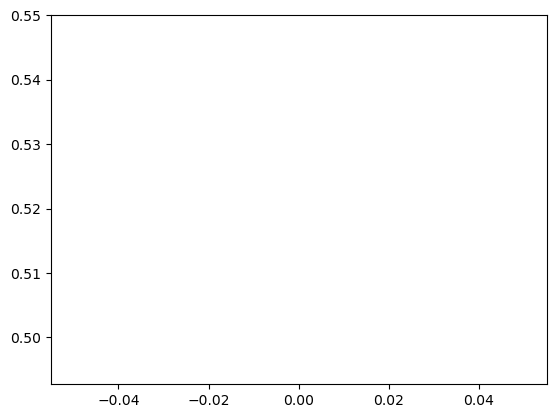

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.187894582748413
val 3.1877975463867188


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view((1,-1)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

cbrpzhxqtb.
hqvufkwmrpxqthtykhkcasskejrzhnbnfqplsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhlm.
poin.
qbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpagmbvdjhksyjrpmqqosozswjcojqmwyljifrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxyh.
xqioloqbplbvbwdn.
ip.
qmuitjpbvfpzpddgpycsislqwkkmco.
zauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyltoorowooktbymouokfbfcw.
zoindzcs.
au.


#|hide

Stop at 13m01s / 1h55m57s

At this point we understand that our hidden layer is sub-optimal from the learning perspective since a lot of the neurons are saturated (in the tails of the tanh). Let's fix that

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # make these smaller
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3135


<matplotlib.image.AxesImage>

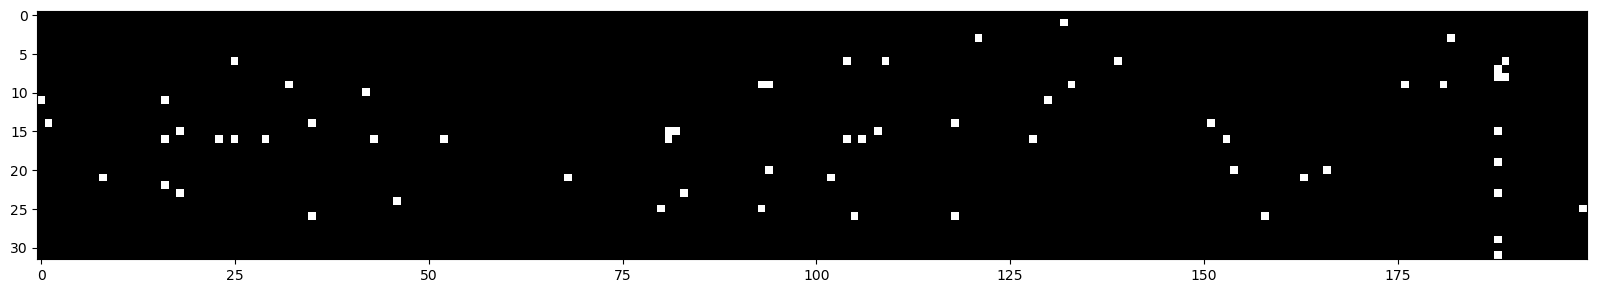

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')#white if True i.e., activations are  > 0.99 (and Black if False)

So we see that no neurons are saturated.

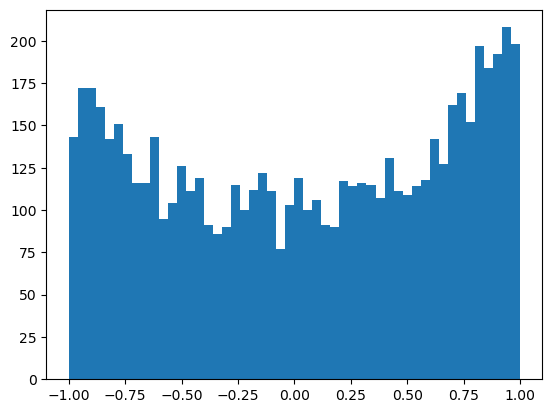

In [ ]:
plt.hist(h.view(-1).tolist(),bins=50);

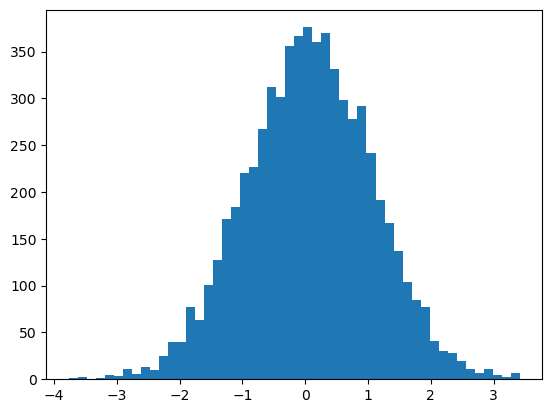

In [ ]:
plt.hist(hpreact.view(-1).tolist(),bins=50);

Now let's run the full optimization without a break

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # make these smaller
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3135
  10000/ 200000: 2.1715
  20000/ 200000: 2.3240
  30000/ 200000: 2.4010
  40000/ 200000: 1.9887
  50000/ 200000: 2.3029
  60000/ 200000: 2.4564
  70000/ 200000: 2.1249
  80000/ 200000: 2.3069
  90000/ 200000: 2.1057
 100000/ 200000: 1.8948
 110000/ 200000: 2.2326
 120000/ 200000: 1.9659
 130000/ 200000: 2.4410
 140000/ 200000: 2.2106
 150000/ 200000: 2.1795
 160000/ 200000: 1.8383
 170000/ 200000: 1.8131
 180000/ 200000: 1.9572
 190000/ 200000: 1.8002


[<matplotlib.lines.Line2D>]

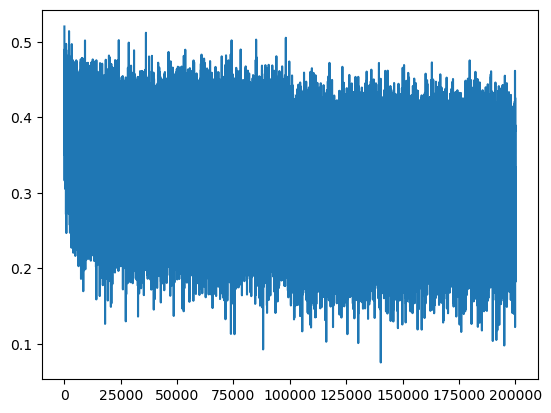

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.036555767059326
val 2.103057622909546


#|hide

Stop at 26m13s / 1h55m57s

## Principled ways to set the scaling parameters

How to come up with the numbers that multiply the different weight matrices and the biases?

tensor(-0.0022) tensor(1.0005)
tensor(-0.0017) tensor(1.0200)


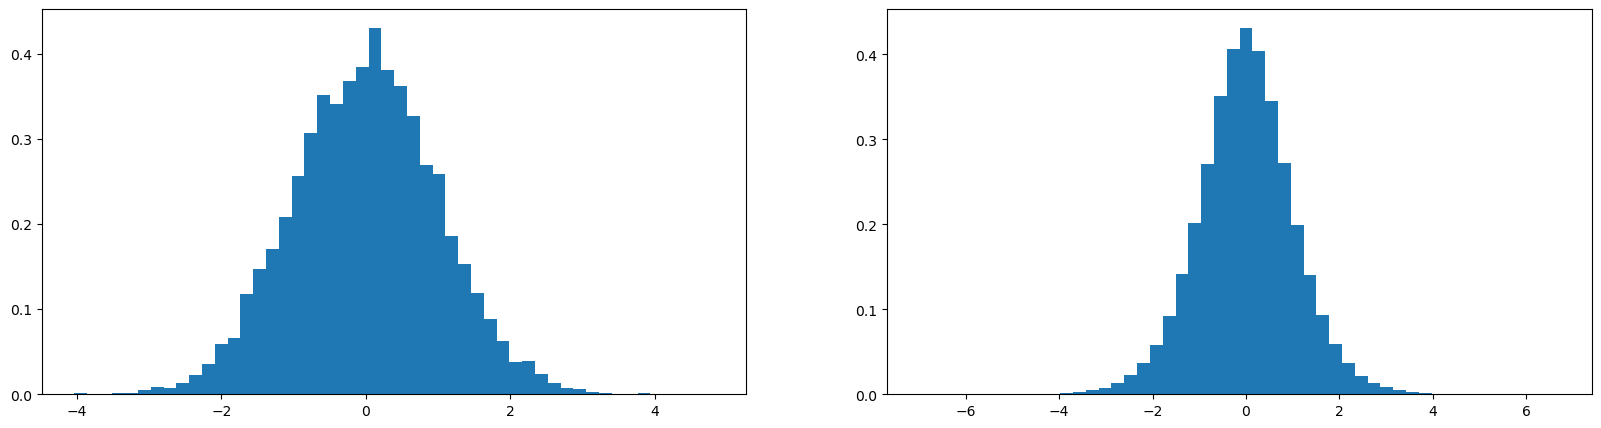

In [ ]:
x = torch.randn(1000,10)
gain = 1
w = torch.randn(10,200) * (gain / (10**0.5)) #scale by square root of the fan-in(the number of inputs)
y = (x@w)
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

Kaiming He's paper Delving Deep into rectifiers..

The big picture is that we want the activations to be unit normal. The problem for tanh is if the activations going into them are too small then the tanh is inactive and if they are too big then the tanh saturates and then nothing flows back in the backward pass (since t = 1)).

Also look at [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html) and then we will see Kaiming normal.

We need a gain term whenever we have a contractive transformation such as relu (which throws away half of the incoming inputs and sets them to zero) or tanh and so on. So to fight this "squeezing in" we have to boost the weights so we can get outputs that are standard Gaussian.

The use of things like residual connections, normalization layers (batch, layer etc), better optimizers (RMSProp and ADAM) have made training of deep networks much less finicky but circa 2016 you would have to be extremely careful about setting these properly.

What does Andrej do? He normalizes the weights by the square root of the fan-in. 

In [ ]:
test = torch.randn(1000000)
test.mean(), test.std()

(tensor(0.0020), tensor(0.9987))

Recall that multiplying the Normal distribution by a number changes it's standard deviation.

In [ ]:
(test*2).mean(), (test*2).std()

(tensor(0.0040), tensor(1.9975))

In [ ]:
hpreact.mean(dim=0,keepdim=True).shape

torch.Size([1, 200])

In [ ]:
hpreact.std(dim=0,keepdim=True).shape

torch.Size([1, 200])

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/(n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * ((1)/(n_hidden)**0.5)
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11697


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.6625
  10000/ 200000: 2.2262
  20000/ 200000: 2.3770
  30000/ 200000: 2.5023
  40000/ 200000: 1.9618
  50000/ 200000: 2.3722
  60000/ 200000: 2.5106
  70000/ 200000: 2.1565
  80000/ 200000: 2.2779
  90000/ 200000: 2.1759
 100000/ 200000: 1.8739
 110000/ 200000: 2.0963
 120000/ 200000: 1.9099
 130000/ 200000: 2.3631
 140000/ 200000: 2.0883
 150000/ 200000: 2.1785
 160000/ 200000: 1.8354
 170000/ 200000: 1.7960
 180000/ 200000: 1.9382
 190000/ 200000: 1.8669


[<matplotlib.lines.Line2D>]

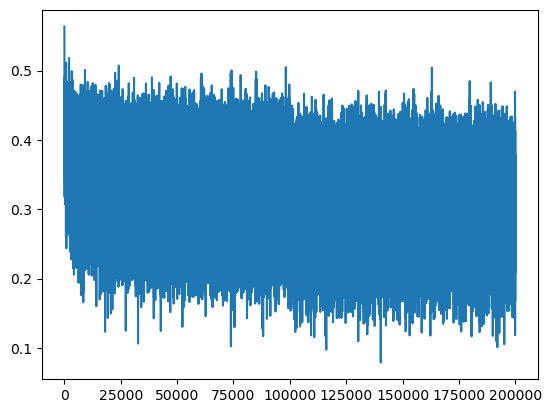

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0383036136627197
val 2.1061367988586426


## Batch Normalization

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/(n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * ((1)/(n_hidden)**0.5)
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain*(hpreact - hpreact.mean(dim=0,keepdim=True))/hpreact.std(dim=0,keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.5772
  10000/ 200000: 2.1652
  20000/ 200000: 2.4167
  30000/ 200000: 2.4436
  40000/ 200000: 2.0111
  50000/ 200000: 2.3681
  60000/ 200000: 2.4293
  70000/ 200000: 2.1056
  80000/ 200000: 2.3539
  90000/ 200000: 2.1389
 100000/ 200000: 1.9417
 110000/ 200000: 2.3648
 120000/ 200000: 1.9323
 130000/ 200000: 2.4825
 140000/ 200000: 2.3174
 150000/ 200000: 2.1054
 160000/ 200000: 1.9776
 170000/ 200000: 1.8040
 180000/ 200000: 1.9797
 190000/ 200000: 1.8384


[<matplotlib.lines.Line2D>]

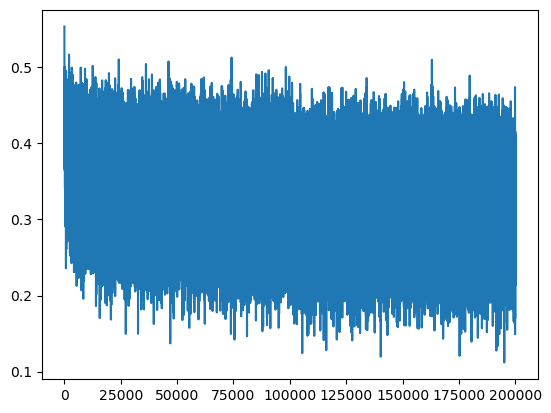

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set 
    bnmean = hpreact.mean(dim=0,keepdim=True)
    bnstd = hpreact.std(dim=0,keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean)/bnstd + bnbias    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068721294403076
val 2.1081509590148926


## Keep running track of bnmean and bnstd

Nobody wants to have a separate step at the end of training where we calculate these stats. So we just calculate them during training.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/(n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * ((1)/(n_hidden)**0.5)
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(dim=0,keepdim=True)
    bnstdi = hpreact.std(dim=0,keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.5772
  10000/ 200000: 2.1652
  20000/ 200000: 2.4167
  30000/ 200000: 2.4436
  40000/ 200000: 2.0111
  50000/ 200000: 2.3681
  60000/ 200000: 2.4293
  70000/ 200000: 2.1056
  80000/ 200000: 2.3539
  90000/ 200000: 2.1389
 100000/ 200000: 1.9417
 110000/ 200000: 2.3648
 120000/ 200000: 1.9323
 130000/ 200000: 2.4825
 140000/ 200000: 2.3174
 150000/ 200000: 2.1054
 160000/ 200000: 1.9776
 170000/ 200000: 1.8040
 180000/ 200000: 1.9797
 190000/ 200000: 1.8384


[<matplotlib.lines.Line2D>]

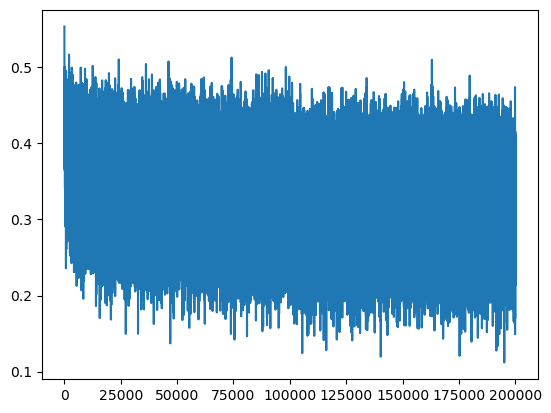

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias  
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068506956100464
val 2.108386993408203


Another point is that we are being wasteful here since b1 plays no role. The batch normalization step cancels out it's effect. So we should just remove it and let the bnbias take over it's place.

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * ((5/3)/(n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #small entropy
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * ((1)/(n_hidden)**0.5)
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
momentum = 0.001

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    
    #Batch Norm Layer
    bnmeani = hpreact.mean(dim=0,keepdim=True)
    bnstdi = hpreact.std(dim=0,keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias #should add a small epsilon to prevent divide by zero
    
    with torch.no_grad():
        bnmean_running = (1-momentum)*bnmean_running + momentum*bnmeani
        bnstd_running = (1-momentum)*bnstd_running + momentum*bnstdi
    # Batch Norm
    # Nonlinearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.6702
  10000/ 200000: 2.0310
  20000/ 200000: 2.5991
  30000/ 200000: 2.0311
  40000/ 200000: 2.2747
  50000/ 200000: 1.8810
  60000/ 200000: 2.1123
  70000/ 200000: 2.3104
  80000/ 200000: 2.3838
  90000/ 200000: 2.0555
 100000/ 200000: 2.3456
 110000/ 200000: 2.2557
 120000/ 200000: 1.6611
 130000/ 200000: 1.8733
 140000/ 200000: 2.3256
 150000/ 200000: 1.9549
 160000/ 200000: 2.0183
 170000/ 200000: 2.3910
 180000/ 200000: 2.1503
 190000/ 200000: 2.0741


[<matplotlib.lines.Line2D>]

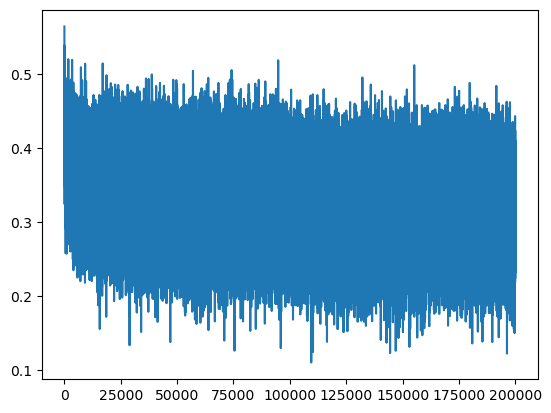

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running + bnbias  
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068607807159424
val 2.108011245727539


#|hide

Stop at 1h04m55s / 1h55m57s

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L143

Bottleneck blocks (repeating motif of conv, bn then relu) are repeated in series in a resnet.

A good thing about batch normalization is that it provides some regularization but a con is that now all the input examples in a batch are coupled. More recently people are using group/layer/instance normalization.

In [ ]:
##### Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), #Tanh(),
#   Linear(           n_hidden, n_hidden), #Tanh(),
#   Linear(           n_hidden, n_hidden), #Tanh(),
#   Linear(           n_hidden, n_hidden), #Tanh(),
#   Linear(           n_hidden, n_hidden), #Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #Try 10 or 0.5 to see what happens instead of 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would need to take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # Keep track of the update to data ratio
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

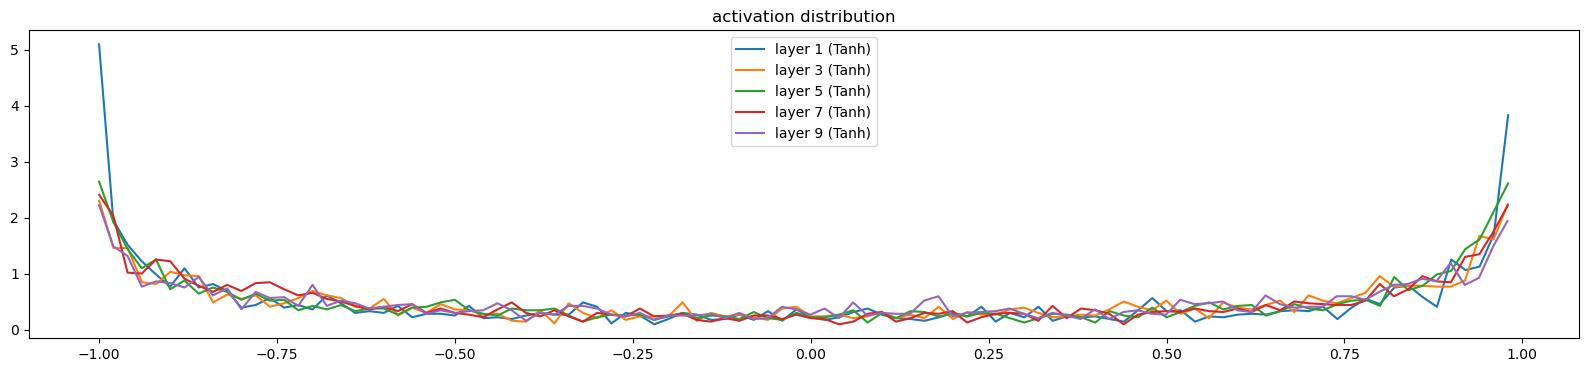

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085332e-03
layer 5 (      Tanh): mean -0.000007, std 2.888205e-03
layer 7 (      Tanh): mean +0.000012, std 2.756315e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'gradient distribution')

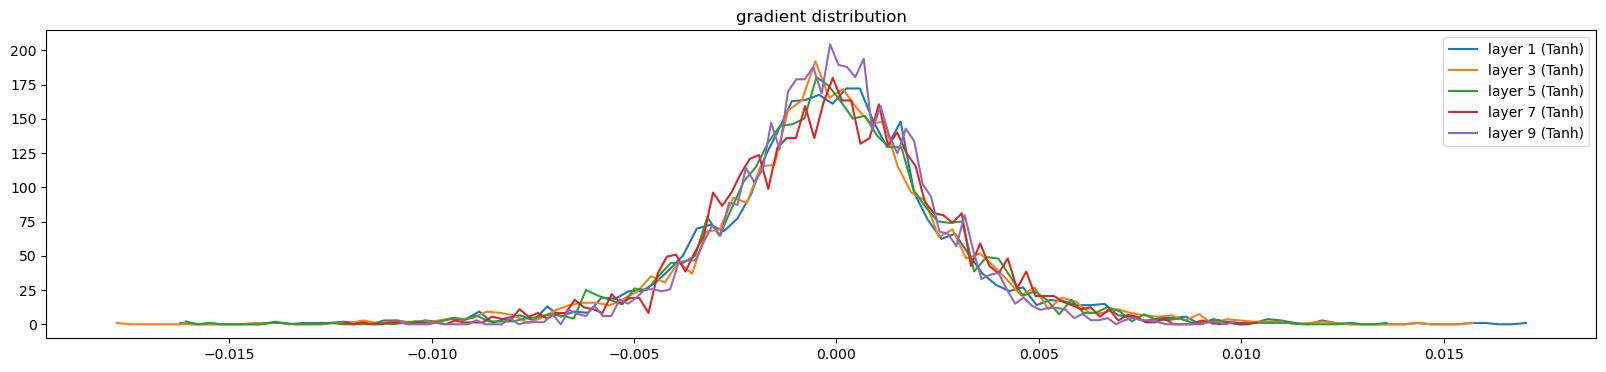

In [ ]:
# visualize histograms
# We want the gradients for all of the layers to be roughly the same
# none of them shrinking to zero or exploding
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

#|hide

Stop at 1h32m11s / 1h55m57s

weight   (27, 10) | mean +0.000772 | std 9.714619e-03 | grad:data ratio 9.714506e-03
weight  (30, 100) | mean -0.000036 | std 8.734047e-03 | grad:data ratio 2.792836e-02
weight (100, 100) | mean +0.000085 | std 7.424626e-03 | grad:data ratio 4.417371e-02
weight (100, 100) | mean +0.000055 | std 6.242014e-03 | grad:data ratio 3.681917e-02
weight (100, 100) | mean +0.000007 | std 6.161662e-03 | grad:data ratio 3.650615e-02
weight (100, 100) | mean +0.000069 | std 5.221999e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229574e-01


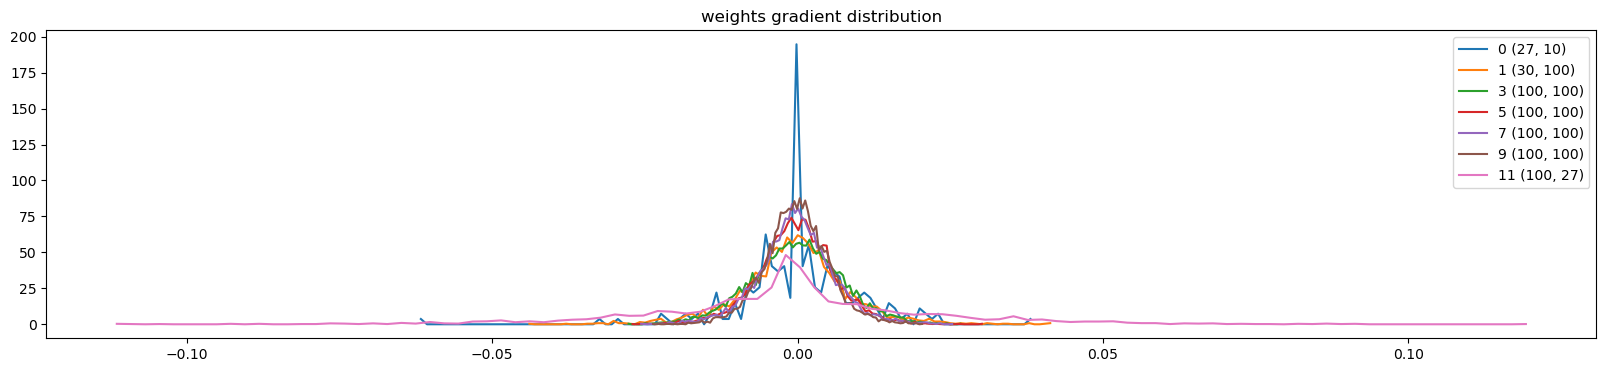

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: #skip biases and gammas and betas of the batch norm
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

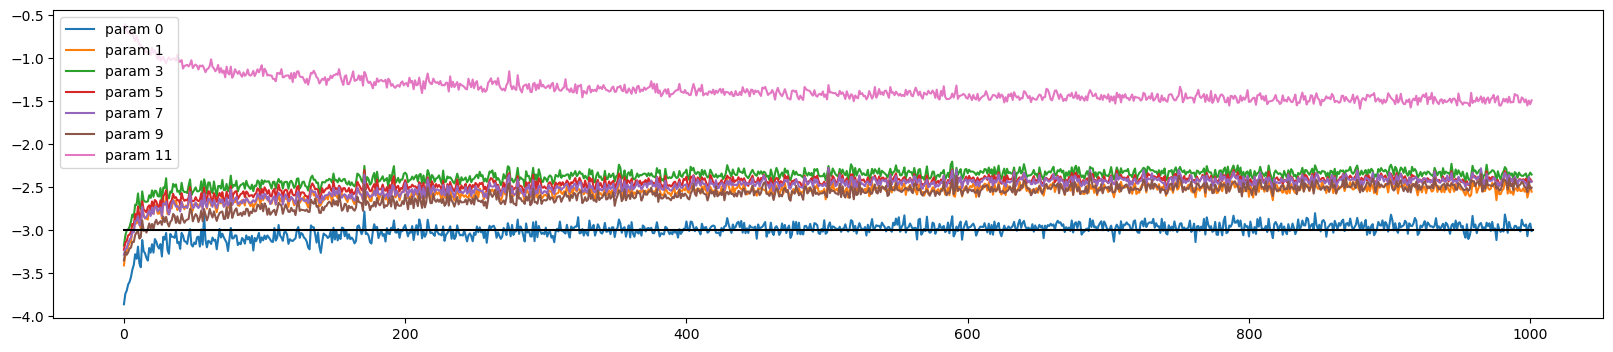

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#|hide

Stop at 1h46m29s / 1h55m57s